In [1]:
from __future__ import division

import argparse, time, logging, random, math

import numpy as np
import mxnet as mx

from mxnet import gluon, nd
from mxnet import autograd as ag
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

from gluoncv.model_zoo import get_model
from gluoncv.utils import makedirs, TrainingHistory
from gluoncv.data import transforms as gcv_transforms
print("Imports successful")

Imports successful


In [2]:
# number of GPUs to use
num_gpus = 1
ctx = [mx.gpu(i) for i in range(num_gpus)]

net = get_model('cifar_resnet56_v1', classes=100)
net.initialize(mx.init.Xavier(), ctx = ctx)
print("Model Init Done.")

Model Init Done.


In [3]:
resize = 32
mean_rgb = [0.485, 0.456, 0.406]
std_rgb = [0.229, 0.224, 0.225]
max_aspect_ratio = 4.0 / 3.0
min_aspect_ratio = 3.0 / 4.0
max_random_area = 1
min_random_area = 0.08
jitter_param = 0.4
lighting_param = 0.1

transform_train = transforms.Compose([
#     transforms.RandomResizedCrop(resize,
#                                  scale=(min_random_area, max_random_area), 
#                                  ratio=(min_aspect_ratio, max_aspect_ratio)),
    
        # Randomly flip the image horizontally
    transforms.RandomFlipLeftRight(),
    
    transforms.RandomBrightness(brightness=jitter_param),
    transforms.RandomSaturation(saturation=jitter_param),
    transforms.RandomHue(hue=jitter_param),
    
    transforms.RandomLighting(lighting_param),
    
    # Randomly crop an area and resize it to be 32x32, then pad it to be 40x40
    gcv_transforms.RandomCrop(32, pad=4),
        
    # Transpose the image from height*width*num_channels to num_channels*height*width
    # and map values from [0, 255] to [0,1]
    transforms.ToTensor(),
    
    # Normalize the image with mean and standard deviation calculated across all images
    transforms.Normalize(mean_rgb, std_rgb),
])

# Since we are using CIFAR100, the images are all of size 32x32. Therefore no center crop is done.
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean_rgb, std_rgb),
])
print("Preprocessing Step Successful.")

Preprocessing Step Successful.


In [4]:
# Batch Size for Each GPU
per_device_batch_size = 128
# Number of data loader workers
num_workers = 2
# Calculate effective total batch size
batch_size = per_device_batch_size * num_gpus

# Set train=True for training data
# Set shuffle=True to shuffle the training data
train_data = gluon.data.DataLoader(
    gluon.data.vision.CIFAR100(train=True).transform_first(transform_train),
    batch_size=batch_size, 
    shuffle=True, 
    last_batch='discard', 
    num_workers=num_workers)

# Set train=False for validation data
# Set shuffle=False to shuffle the testing data
val_data = gluon.data.DataLoader(
    gluon.data.vision.CIFAR100(train=False).transform_first(transform_test),
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers)
print("Initialization of train_data and val_data successful.")

Initialization of train_data and val_data successful.


In [7]:
# Learning rate decay factor
lr_decay = 0.1
# Epochs where learning rate decays
lr_decay_epoch = [30, 60, 90, np.inf]

# Adam optimizer using default parameters recommended in MachineLearningMastery.com
optimizer = 'adam'
optimizer_params = {'learning_rate': 0.001,
                    'beta1': 0.9,
                    'beta2': 0.999,
                    'epsilon':10e-8}

# Define our trainer for net
trainer = gluon.Trainer(net.collect_params(), optimizer, optimizer_params)

loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

train_metric = mx.metric.Accuracy()
train_history = TrainingHistory(['training-error', 'validation-error'])

In [8]:
def test(ctx, val_data):
    metric = mx.metric.Accuracy()
    for i, batch in enumerate(val_data):
        data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0)
        label = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0)
        outputs = [net(X) for X in data]
        metric.update(label, outputs)
    return metric.get()

Training loop started:
[Epoch 0] train=0.170913 val=0.241300 loss=136735.996033 time: 31.765953
[Epoch 1] train=0.292909 val=0.340000 loss=113135.162064 time: 31.608158
[Epoch 2] train=0.367668 val=0.374700 loss=100769.268036 time: 31.675509
[Epoch 3] train=0.417087 val=0.412300 loss=92240.715729 time: 31.551225
[Epoch 4] train=0.461078 val=0.482500 loss=84959.690170 time: 31.489980
[Epoch 5] train=0.496835 val=0.500400 loss=79570.799179 time: 31.517719
[Epoch 6] train=0.522656 val=0.469000 loss=74753.475220 time: 31.548121
[Epoch 7] train=0.548718 val=0.537700 loss=70674.872345 time: 31.554014
[Epoch 8] train=0.569391 val=0.567600 loss=67587.618179 time: 31.591007
[Epoch 9] train=0.589123 val=0.568000 loss=64431.363937 time: 31.771161
[Epoch 10] train=0.600621 val=0.596100 loss=62049.830833 time: 31.379682
[Epoch 11] train=0.615545 val=0.595000 loss=59789.576927 time: 31.650404
[Epoch 12] train=0.627384 val=0.623900 loss=57885.659454 time: 31.668793
[Epoch 13] train=0.640465 val=0.607

[Epoch 112] train=0.877644 val=0.736600 loss=18536.547167 time: 31.591755
[Epoch 113] train=0.876683 val=0.736700 loss=18562.099024 time: 31.671053
[Epoch 114] train=0.878385 val=0.737200 loss=18463.170204 time: 31.938352
[Epoch 115] train=0.878646 val=0.737100 loss=18478.394690 time: 31.368691
[Epoch 116] train=0.876703 val=0.738100 loss=18697.911213 time: 31.661418
[Epoch 117] train=0.879527 val=0.738100 loss=18353.435616 time: 31.572303
[Epoch 118] train=0.877504 val=0.736600 loss=18605.109114 time: 31.667896
[Epoch 119] train=0.879026 val=0.737600 loss=18252.468145 time: 31.737233
Done.


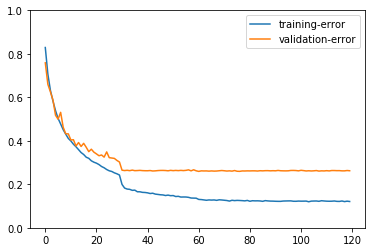

In [9]:
epochs = 120
lr_decay_count = 0

print("Training loop started:")
for epoch in range(epochs):
    tic = time.time()
    train_metric.reset()
    train_loss = 0

    # Learning rate decay
    if epoch == lr_decay_epoch[lr_decay_count]:
        trainer.set_learning_rate(trainer.learning_rate*lr_decay)
        lr_decay_count += 1

    # Loop through each batch of training data
    for i, batch in enumerate(train_data):
        # Extract data and label
        data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0)
        label = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0)

        # AutoGrad
        with ag.record():
            output = [net(X) for X in data]
            loss = [loss_fn(yhat, y) for yhat, y in zip(output, label)]

        # Backpropagation
        for l in loss:
            l.backward()

        # Optimize
        trainer.step(batch_size)

        # Update metrics
        train_loss += sum([l.sum().asscalar() for l in loss])
        train_metric.update(label, output)

    name, acc = train_metric.get()
    # Evaluate on Validation data
    name, val_acc = test(ctx, val_data)

    # Update history and print metrics
    train_history.update([1-acc, 1-val_acc])
    print('[Epoch %d] train=%f val=%f loss=%f time: %f' %
        (epoch, acc, val_acc, train_loss, time.time()-tic))

# We can plot the metric scores with:
train_history.plot(['training-error', 'validation-error'], save_path="./cifar100_resnet56_v1_adam.png")
print("Done.")